In [4]:
import os

import Bio
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

import numpy
import numpy as np
import matplotlib.pyplot as plt
import argparse
import uuid

from abc import ABC
from abc import abstractmethod

In [118]:
class OperationSet(ABC):
    """Abstract class for a collection of functions which are designed to operate on a given context"""
    
    def __init__(self):
        pass
    
    @abstractmethod
    def valid_input():
        """To be overridden by all children of this class. Determines if a given input is appropriate for this set of operations."""
        raise NotImplementedError("valid_inputs has not been overridden in a child class")

class NumberComperisons(OperationSet):
    """Implements equalish"""
    def __init__(self):
        super().__init__()
    
    @staticmethod
    def eq_ish(a,b,cutoff=.01):
        return abs(b-a) < cutoff
    

class PointCloudOperations(OperationSet):
    """
        Sets of operations which are designed to be used on abstract clouds of points
        
    
    """
    
    def __init__(self):
        super().__init__()
        
    @staticmethod
    def valid_input():
        return True
        
    def apply_rotation(self, M, R):

        """Takes a set of points"""
    
        assert M.shape[-1] ==3
        
        get_diagonal = lambda x: (x[0][0], x[1][1], x[2][2])

        return numpy.array(list(map(get_diagonal, [point*R for point in M])))
    
    def center_of_mass(self, coords):

        """Return the center of mass of a point set."""
        
        
        
        return numpy.mean(numpy.array(coords).T, axis=1)
        
    def apply_translation(self, points, translation):

        """Return the center of mass"""
        points=numpy.array(points)
        translation=numpy.array(points)
        
        return (points + translation)
    
    def compute_rotation(self, from_coords, to_coords):

        """Compute a rotation. Assumes that both point clouds are at the origin."""
        to_coords = numpy.array(to_coords).T
        from_coords = numpy.array(from_coords).T
        
        H = to_coords @ np.transpose(from_coords)

        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T   
        return R
    
    
    def superimpose(self, from_coords, to_coords, resids=None, origin_both = True):

        """Superimposes two structures -- assumes that point clouds stricly contain the same elements
            Finds the midpoint, translates both to the origin. 
            originally this was intended to move model 1 to model 2 but it ended up making more sense to translate both of them to the origin"""

        from_coords = numpy.array(from_coords)
        to_coords = numpy.array(to_coords)

        assert from_coords.shape == to_coords.shape, "The shape of the input arrays did not match up."

        to_centroid = self.center_of_mass(to_coords)
        from_centroid = self.center_of_mass(from_coords)

        to_coords = self.apply_translation(to_coords, -to_centroid)
        from_coords = self.apply_translation(from_coords, -from_centroid)

        R = self.compute_rotation(from_coords,to_coords)
        
        transformed_from = self.apply_rotation(from_coords, R)
        transformed_to = to_coords
        
        if not origin_both:
            transformed_from = self.apply_translation(transformed_from, to_centroid)
            transformed_to = self.apply_translation(transformed_to, to_centroid)
        

        return transformed_from.T, transformed_to.T
    

    def scatter_3d(self, point_groups = [], axis_labels = ['PC1', 'PC2', 'PC3'], filename = None):
        
        """Produces a 3d scatter plot of all of the points in 3 provided lists"""
        
        markers= ["o", "^"]

        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        for pg in point_groups:
            xs = list(map(lambda x: x[0], pg))
            ys = list(map(lambda x: x[1], pg))
            zs = list(map(lambda x: x[2], pg))
            m = markers[0]
            ax.scatter(xs, ys, zs,marker=m)

        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])
        ax.set_zlabel(axis_labels[2])


        if filename != None:
            plt.savefig(filename)
        else: 
            plt.show()

   
    def lists_to_zipped_list(self, things: list):
        """Take X lists of N elements and return N lists of X elements
            Just uses the transpose function on a numpy array
            Was previouly casting the return type but that ended up being problematic so we will assume that an numpy array is the ideal return type
            This function should really be removed. It does not make sense to not just transpose... can keep if additional logic is going to be added going forwards"""

        if type(things) != numpy.ndarray:
            tmp = numpy.array(things)
        else:
            tmp = things

        assert len(tmp.shape) ==2, "The dimensions of your input to lists_to_zipped_list did not make sense."

        return tmp.T
        
class pdb_file:
    """Takes a filename and allows you to pull information out i"""
    
    def __init__(self, filename, pdb_parser = None):
        
        if pdb_parser == None:
            pdb_parser = PDBParser()
        
        self.filename = filename
        self.uuid = uuid.uuid4()
        self.structure = pdb_parser.get_structure(str(self.uuid), self.filename)
        self.model = self.structure[0]
        self.dssp = DSSP(self.model, self.filename)

    def get_model(self):
        return self.model
    
    def get_uuid(self):
        return self.uuid
    
    def get_filename(self):
        return self.filename

    def get_structure(self):
        return self.structure
    
    def get_dssp(self):
        return self.dssp

    def center_of_mass(self):
        return self.structure.center_of_mass()
            
    def get_coords(self):
        """asdfasdf"""
        
        return numpy.array([atom.get_coord() for atom in self.model.get_atoms() if atom.get_full_id()[3][1] in resids]).T

    def get_contiguous(self, ele_types = ["H"]):
        
        """Computes sets of residues which should be included in the final region"""
        ds_prop = self.get_dssp().property_dict
        id_list = list(map(lambda x: x[0], ds_prop.values()))
        ss_call = list(map(lambda x: x[2], ds_prop.values()))
        ds_dict = dict(zip(id_list, ss_call))

        helical_ids = dict(
                        list(
                            filter(lambda x: x[1] in ele_types, ds_dict.items()
                                  )
                        )
        ).keys()

        start = helical_ids[0] # The elements that started the segment of 
        last = helical_ids[0]

        contiguous_regions = [] 

        for i in helical_ids:

            if i == last+1:
                pass
            else:
                if start != last:
                    helices.append((start,last))
                start = i

            last = i
            
        if start != last:
            helices.append((start,last+1))

        return helices


# args
# p = PDBParser()

'''
argparser = argparse.ArgumentParser(description="Superimpose two structures and compute some variance metrics")
argparser.add_argument('file_1')
argparser.add_argument('file_2')

args = argparser.parse_args()
'''


args = {
    "file_1":"unrelaxed_structure_8_model_5.pdb",
    "file_2":"unrelaxed_structure_9_model_5.pdb"
}

structure = pdb_file(args['file_1'])
structure1 = pdb_file(args['file_2'])

# structure = p.get_structure('struct_0', args['file_1'])
# model = structure[0]
# dssp = DSSP(model,args['file_1'])

# structure1 = p.get_structure('struct_0', args['file_2'])
# model1 = structure1[0]
# dssp1 = DSSP(model1,args['file_2'])



# structure.get_coords()
# structure.get_coords()
# cd1, cd2 = superimpose(structure.get_coords(),structure1.get_coords())



In [387]:
# pdb1 = pdb_file("unrelaxed_structure_8_model_5.pdb")

In [48]:
# dssp= structure.get_dssp()
# resids = [p for l in structure.get_contiguous(dssp.property_dict.items()) for p in l]
# dssp.property_dict.values()
# [p for l in dssp.property_dict.values() for p in l]

In [363]:
# structure.center_of_mass()

# cd1_rot, cd2_rot = superimpose(model,model1)

# scatter_3d(point_groups = [cd1,cd2])

In [364]:
# structure1.center_of_mass()

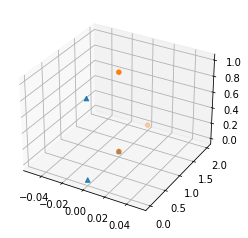

In [50]:
# lists_to_zipped_list()
points_1= [[0,0,0],
 [0,1,0],
 [0,0,1],
 [0,0,0]
]
points_2= [[0,1,0],
 [0,2,0],
 [0,1,1],
 [0,1,0]
]

PCO = PointCloudOperations()
# points_1,points_2 = PCO.superimpose(points_1,points_2)
fig = plt.figure()
# markers= ["o", "^"]


ax = fig.add_subplot(projection='3d')

x,y,z =lists_to_zipped_list(points_1)
ax.scatter(x,y,z, marker="^")


x2,y2,z2 = PCO.lists_to_zipped_list(points_2)
ax.scatter(x2,y2,z2)

plt.show()



In [51]:
# numpy.array(points_1).T

In [52]:
# points_2


In [9]:
# def lists_to_zipped_list(things: list):
#         """Take X lists of N elements and return N lists of X elements
#             Just uses the transpose function on a numpy array
#             Was previouly casting the return type but that ended up being problematic so we will assume that an numpy array is the ideal return type
#             This function should really be removed. It does not make sense to not just transpose... can keep if additional logic is going to be added going forwards"""

#         if type(things) != numpy.ndarray:
#             tmp = numpy.array(things)
#         else:
#             tmp = things

#         assert len(tmp.shape) ==2, "The dimensions of your input to lists_to_zipped_list did not make sense."

#         return tmp.T

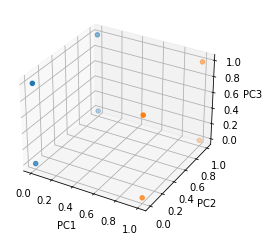

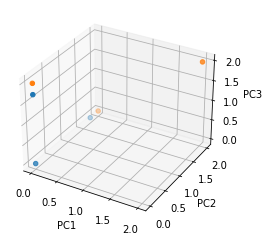

In [138]:
points_1 = [
    [0,0,0],
    [0,1,0],
    [0,0,1],
    [0,1,1],
]

points_2 = [
    [1,0,0],
    [1,1,0],
    [1,0,1],
    [1,1,1],
]
PCO=PointCloudOperations()


PCO.scatter_3d(point_groups=[points_1,points_2])

points_1, points_2 = PCO.superimpose(points_1,points_2)
PCO.scatter_3d(point_groups=[points_1,points_2])

# PCO.compute_rotation(points_1,points_2)

# centroid_1 = PCO.center_of_mass(points_1)
# PCO.apply_translation(points_1, centroid_1)
# centroid_1

In [139]:
points_1

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.72760688, 0.        , 1.72760688],
       [0.        , 0.        , 1.72760688, 1.72760688]])

In [140]:
points_2

array([[2, 2, 2, 2],
       [0, 2, 0, 2],
       [0, 0, 2, 2]])